Create a file called ref_trajectory.py. Copy the functions from week3 that enabled you to generate a trajectory given a sequence of straight/ turn commands

In [1]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ref_trajectory import generate_trajectory as traj
%matplotlib inline

In [2]:
!tree

.
├── __pycache__
│   └── ref_trajectory.cpython-37.pyc
├── data
│   ├── circuit.png
│   └── config.toml
└── ref_trajectory.py

2 directories, 4 files


We will look at 2 ways to make a grid 

(a) Load an existing circuit (Use MS paint or anything else)

(b) Make a custom grid

Remember grid resolution is the key parameter to go from grid co-ordinates to world co-ordinates. What is the value of 1 pixel?

Grid shape: (557, 766)
Grid shape in m is (27.85, 38.300000000000004)


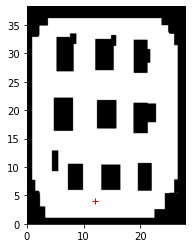

In [3]:
grid_res = 0.05 # Resolution in m / pixel
# Open the test circuit (8-bit pixels b/w with alpha)
#  image flipped so that the origin is at bottom left corner instead of
#  top left
img_path = "./data/circuit.png"
img = Image.open(img_path).convert('L').transpose(Image.FLIP_TOP_BOTTOM)
grid_data = (1 - np.array(img)/255) # Occupancy grid: 1 - occupied, 0 - free

#find the shape
grid_shape = grid_data.shape
print(f"Grid shape: {grid_shape}")

#find the real-world extents of the grid: opposite vertices of the rectangle
x1, y1 = 0, 0
#use shape and grid_res to calculate the top-right vertex
x2, y2 =  np.array(grid_shape) * grid_res # pixel to m
print(f"Grid shape in m is {x2, y2}")
#display the image using imshow()
#pay attention to the keywords origin, cmap and extent
#Default origin is top-left, but we should use 'lower'
#how should grid_data be transformed
plt.figure()
plt.imshow(grid_data, cmap = plt.cm.gray_r, extent=[x1,x2,y1,y2], origin='lower')
start_pose = np.array([12, 4, np.pi/2])
plt.plot(start_pose[0], start_pose[1],'r+')
plt.show()

Rectangle at (500, 520, 200, 800)
Rectangle at (40, 160, 320, 400)


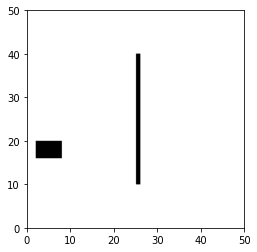

In [4]:
#custom grid
#choose resolution and dimensions
grid_res = 0.05 # m / pixel
grid_span =  50 # square circuit dimensions in m
grid_span = np.repeat(grid_span, 2)
#calculate grid_shape from grid
# dimensions have to be integers (W, H)
grid_shape = (grid_span/grid_res).astype('int')
#Initialize
grid_data = np.zeros(grid_shape)

#Create rectangular obstacles in world co-ordinates
# [xmin, xmax, ymin, ymax]
obstacles = np.array([[25, 26, 10, 40],
                       [2, 8, 16, 20]]) 
for obs in obstacles:
    # calculate obstacles extent in pixel coords
    xmin, xmax, ymin, ymax = (obs/grid_res).astype('int')
    print(f"Rectangle at {xmin, xmax, ymin, ymax}")
    # mark them as occupied
    #  Note: Transpose the output, as Y is outer and X is inner in imshow
    grid_data[xmin:xmax, ymin:ymax] = 1.0

#calculate the extents
x1, y1 = 0, 0
x2, y2 = grid_span

#imshow() from prior cell
plt.figure()
plt.imshow(grid_data.T, cmap=plt.cm.gray_r, origin='lower', extent=[x1, x2, y1, y2])

Plot the reference trajectory on the grid environment

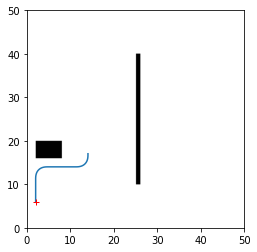

In [5]:
#pick a suitable starting pose
start_pose = np.array([2, 6, np.pi/2])
#we will use same route as before
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]

#calculate ref_path from traj()
# we want it to be numpy array of dimensions (N, 3)
x_ref, y_ref, th_ref = traj(route, start_pose)
ref_path = np.array([x_ref, y_ref, th_ref]).T

#plot the grid and 
plt.figure()
plt.imshow(grid_data.T, origin='lower', cmap=plt.cm.gray_r, extent=[x1, x2, y1, y2])
plt.plot(ref_path[:,0], ref_path[:,1])  # Plot X and Y values
plt.plot(start_pose[0], start_pose[1],'r+')

Let us now use circle approximation to perform collision checking. We will use w=0.8, l=1.2m as mule dimensions. Calculate the 4 vertices of the mule

Circle parameters are offset and radii

You would have to plot the mule rectangle and 3 circles

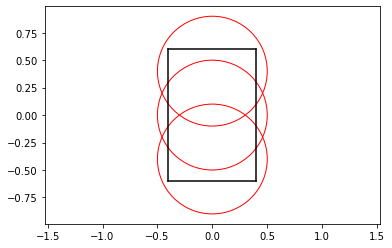

In [6]:
w=0.8
l=1.2
mule_extents = np.array([[-w/2, -l/2],  # Bottom left
                         [w/2, -l/2], # Bottom right
                         [w/2, l/2],  # Top right
                         [-w/2, l/2]]) # Top left

r = 0.5
l = 0.4
circles = [(0, 0, r), (0, l, r), (0, -l, r)]

plt.figure()
plt.axis('equal')
#plot rectangle or just the 4 vertices
plt.plot([mule_extents[0, 0], mule_extents[1, 0]], 
         [mule_extents[0, 1], mule_extents[1, 1]], 'k')
plt.plot([mule_extents[1, 0], mule_extents[2, 0]], 
         [mule_extents[1, 1], mule_extents[2, 1]], 'k')
plt.plot([mule_extents[2, 0], mule_extents[3, 0]], 
         [mule_extents[2, 1], mule_extents[3, 1]], 'k')
plt.plot([mule_extents[3, 0], mule_extents[0, 0]], 
         [mule_extents[3, 1], mule_extents[0, 1]], 'k')
ax = plt.gca()
for x,y, rad in circles:
  ax.add_patch(plt.Circle((x, y), rad, fill=False, color='r'))


Write a function to find if there is a collision given the grid and the local path

1. Rotate the 3 circle vertices along the local path

2. Check if $(x-x_c)^2 + (y-y_c)^2 < r$ and grid[x, y] = 1.0

3. Return True or False

You can assume circles variable (approximation of the vehicle dimensions) is assumed as a global variable

What do you think is a simple unit test?

In [7]:
def circle_collision_check(grid, local_traj):
  xmax, ymax = grid.shape
  all_x = np.arange(xmax)
  all_y = np.arange(ymax)
  # Create a meshgri (all points). Note that X and Y are matrices
  X, Y = np.meshgrid(all_x, all_y)
  for x, y, t in local_traj:
    # Rotation matrice for the trajectory
    rot = np.array([[np.sin(t), -np.cos(t)],[np.cos(t), np.sin(t)]])
    for xc, yc, rc in circles:
      # Get the center of the circle in the rotated frame
      xc_rot, yc_rot = rot @ np.array([xc, yc]) + np.array([x, y])
      # Convert to pixel coordinates
      xc_pix, yc_pix = int(xc_rot/grid_res), int(yc_rot/ grid_res)
      rc_pix = (rc/ grid_res)
      inside_circle = ((X-xc_pix)**2 +(Y-yc_pix)**2 - rc_pix**2 < 0)
      occupied_pt = grid[X, Y] == 1
      if np.sum(np.multiply( inside_circle, occupied_pt)):
        return True
  return False

True


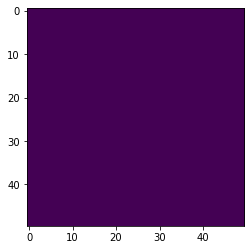

In [8]:
local_traj = np.array([[0, 0, np.pi/2]])
grid = np.ones([50, 50])  # This has to collide!
print(circle_collision_check(grid, local_traj))
plt.imshow(grid)

Let us move onto the more complicated swath collision checking

Write a function to trace the footprint of the vehicle along the local path.

Input: grid_size, local path
Output: footprint

Start with an empty grid of similar size

1. Rotate the 4 vertices of the mule rectangle along the local path

2. Collect all the vertices and calculate the convex hull. Remember to typecast them as float32 as cv2..convexHull() expects that

3. Use fillConvexPoly() to fill up the hull

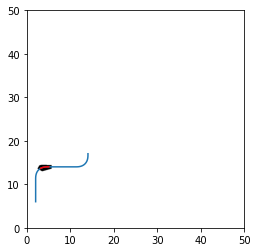

In [9]:
def swath_footprint(local_path,grid_size):
  #initialize image
  img = np.zeros(grid_size)
  vertices = []
  for x,y,t in local_path:
    rot = np.array([[np.sin(t), -np.cos(t)], [np.cos(t), np.sin(t)]])
    for vertex in mule_extents:
      rot_vertex = rot @ vertex + np.array([x, y])
      vertices.append(rot_vertex)
  vertices = np.array(vertices,dtype='float32')
  hull_vertices = cv.convexHull(vertices)
  #change hull vertices to grid coords and typecast as int32
  hull_vertices = (hull_vertices/grid_res).astype('int32')
  cv.fillConvexPoly(img,hull_vertices,1)
  return img.T == 1

s, e = 40, 60
footprint = swath_footprint(ref_path[s:e], grid_data.shape)
plt.imshow(1-footprint.T,cmap='gray', origin='lower', extent=[x1, x2, y1, y2])
plt.plot(ref_path[:,0], ref_path[:,1])
plt.plot(ref_path[s:e,0], ref_path[s:e,1], 'r')

Once you know the footprint, it should be easy to see if the footprint coincides with any occupied cells in the original grid



## Examples

Try out some examples to unit test your code for both circle checking and swath checking

In practice, you can write this as a CollisionChecking class where the mule dimensions are read from a config file and initialized. Global variables are best avoided in production code.

In [10]:
%reset -f

In [11]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ref_trajectory import generate_trajectory as traj
import time

%matplotlib inline

In [12]:
# Map here
!tree

.
├── __pycache__
│   └── ref_trajectory.cpython-37.pyc
├── data
│   ├── circuit.png
│   └── config.toml
└── ref_trajectory.py

2 directories, 4 files


### Simple path collision

- Get map from image
- Create a path on the map
- Check for collision using
  - `Fast Collision Checking`


Image of size (766, 557) loaded
Image size (766, 557), min: 0.0, max: 1.0
Real world dimensions (W, H): 38.30, 27.85


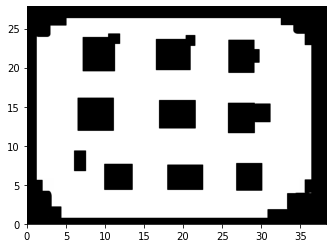

In [13]:
# Load the map
map_path = "./data/circuit.png"
grid_res = 0.05 # Resolution: m / pixel
image = Image.open(map_path).convert("L").transpose(Image.FLIP_TOP_BOTTOM)
print(f"Image of size {image.size} loaded")
map_np = 1 - np.array(image).T / 255.0  # Transpose so that index is [X, Y]
print(f"Image size {map_np.shape}, min: {np.min(map_np)}, max: {np.max(map_np)}")
dw, dh = np.array(map_np.shape) * grid_res
print(f"Real world dimensions (W, H): {dw:.2f}, {dh:.2f}")
x1, y1 = 0, 0
x2, y2 = dw, dh
# Show it using imshow
plt.figure()
plt.imshow(map_np.T, origin="lower", cmap=plt.cm.gray_r, extent=[x1, x2, y1, y2])

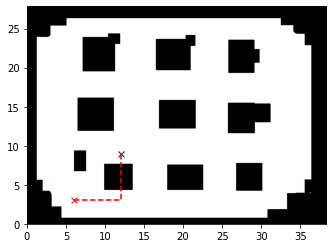

In [14]:
# Put the start and end points on the map
start_point = (6, 3)  # m, m
end_point = (12, 9) # m, m
res = (0.05, 0.05)  # Resolution in path: in cm
# Create path, DX, then DY
path1 = np.array(list((i, start_point[1], 0) for i in \
              np.arange(start_point[0], end_point[0], res[0])))
path2 = np.array(list((end_point[0], i, np.pi/2) for i in \
              np.arange(start_point[1], end_point[1], res[1])))
ref_path = np.vstack((path1, path2))
# Plot it
plt.figure()
spx, spy = np.array(start_point)
plt.plot(spx, spy, 'rx')
epx, epy = np.array(end_point)
plt.plot(epx, epy, 'bx')
plt.plot(ref_path[:, 0], ref_path[:, 1], 'r--')
plt.imshow(map_np.T, origin="lower", cmap=plt.cm.gray_r, extent=[x1, x2, y1, y2])

In [15]:
# Collision check using circles
def circle_collision_check(grid, local_traj):
  xmax, ymax = grid.shape
  all_x = np.arange(xmax)
  all_y = np.arange(ymax)
  # Create a meshgri (all points). Note that X and Y are matrices
  X, Y = np.meshgrid(all_x, all_y)
  for x, y, t in local_traj:
    # Rotation matrice for the trajectory
    rot = np.array([[np.sin(t), -np.cos(t)],[np.cos(t), np.sin(t)]])
    for xc, yc, rc in circles:
      # Get the center of the circle in the rotated frame
      xc_rot, yc_rot = rot @ np.array([xc, yc]) + np.array([x, y])
      # Convert to pixel coordinates
      xc_pix, yc_pix = int(xc_rot/grid_res), int(yc_rot/ grid_res)
      rc_pix = (rc/ grid_res)
      # Conditions for collision
      inside_circle = ((X-xc_pix)**2 +(Y-yc_pix)**2 - rc_pix**2 < 0)
      occupied_pt = grid[X, Y] == 1
      if np.sum(np.multiply(inside_circle, occupied_pt)):
        return True
  return False

Vehicle

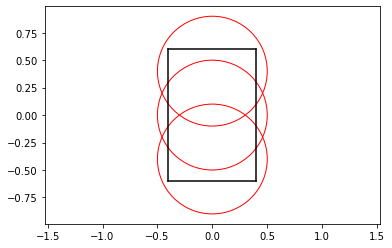

In [16]:
# Same vehicle
w=0.8
l=1.2
mule_extents = np.array([[-w/2, -l/2],  # Bottom left
                         [w/2, -l/2], # Bottom right
                         [w/2, l/2],  # Top right
                         [-w/2, l/2]]) # Top left

r = 0.5
l = 0.4
circles = [(0, 0, r), (0, l, r), (0, -l, r)]

plt.figure()
plt.axis('equal')
#plot rectangle or just the 4 vertices
plt.plot([mule_extents[0, 0], mule_extents[1, 0]], 
         [mule_extents[0, 1], mule_extents[1, 1]], 'k')
plt.plot([mule_extents[1, 0], mule_extents[2, 0]], 
         [mule_extents[1, 1], mule_extents[2, 1]], 'k')
plt.plot([mule_extents[2, 0], mule_extents[3, 0]], 
         [mule_extents[2, 1], mule_extents[3, 1]], 'k')
plt.plot([mule_extents[3, 0], mule_extents[0, 0]], 
         [mule_extents[3, 1], mule_extents[0, 1]], 'k')
ax = plt.gca()
for x,y, rad in circles:
  ax.add_patch(plt.Circle((x, y), rad, fill=False, color='r'))

Main collision check

In [17]:
start_time = time.time()
# Perform collision checking on the path above for the grid imported
collision_condition = circle_collision_check(map_np, ref_path)
if collision_condition:
  # Try going from (6, 3) to (12, 9) for an obstructed path
  print("Path has obstacles")
else:
  # Try going from (6, 3) to (16, 9) for a free path
  print("Path is free to traverse")
end_time = time.time()
print(f"Time taken for circle collision check: {end_time - start_time:.3f} sec")

Path has obstacles
Time taken for circle collision check: 5.206 sec


### Swath collision checking

Get the `swath footprint` for all parts and then check the mask comparison

In [18]:
# Function for swath footprint
def swath_footprint(local_path, grid_size):
  #initialize image
  img = np.zeros(grid_size)
  vertices = []
  for x,y,t in local_path:
    rot = np.array([[np.sin(t), -np.cos(t)], [np.cos(t), np.sin(t)]])
    for vertex in mule_extents:
      rot_vertex = rot @ vertex + np.array([x, y])
      vertices.append(rot_vertex)
  vertices = np.array(vertices,dtype='float32')
  # Swap X, Y to Y, X because the indices we use is like that (for OpenCV)
  vertices_true = np.hstack((vertices[:, 1].reshape(-1, 1), vertices[:, 0].reshape(-1, 1)))
  hull_vertices = cv.convexHull(vertices_true)
  #change hull vertices to grid coords and typecast as int32
  hull_vertices = (hull_vertices/grid_res).astype('int32')
  cv.fillConvexPoly(img, hull_vertices, 1)
  return img.astype('int')

In [19]:
# Function for swath collision checking (check segment size of 10)
def swath_collision_check(grid, local_traj, path_res = 30):
  split_points = np.arange(0, ref_path.shape[0], path_res)
  swath_img = np.zeros_like(grid).astype('int')
  for s in split_points:
    start_seg, end_seg = s, min(s + path_res, local_traj.shape[0])
    # Get the swath footprint
    simg = swath_footprint(local_traj[start_seg:end_seg], grid.shape).astype('int')
    swath_img = cv.bitwise_or(swath_img, simg)
  # Check if the bitwise and with the grid is a valid image
  collision_res = cv.bitwise_and(swath_img, grid.astype('int'))
  if (np.sum(collision_res)): # Path has obstacles
    return True
  # Path is free
  return False

In [20]:
start_time = time.time()
# Perform collision checking on the path above for the grid imported
collision_condition = swath_collision_check(map_np, ref_path, 5)
if collision_condition:
  # Try going from (6, 3) to (12, 9) for an obstructed path
  print("Path has obstacles")
else:
  # Try going from (6, 3) to (16, 9) for a free path
  print("Path is free to traverse")
end_time = time.time()
print(f"Time taken for circle collision check: {end_time - start_time:.3f} sec")

Path has obstacles
Time taken for circle collision check: 0.308 sec
